# Data Pre-Processing

Citations:
- [TA provided sample project](https://elearn.ucr.edu/courses/104198/pages/sample-project-material?module_item_id=1752456)
- [Google Drive Mounting and Folder Path](https://stackoverflow.com/questions/72199130/google-colab-import-data-from-google-drive-and-make-it-possible-to-share-it)
- [SKLearn Libraries for Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- Preprocessing/Metric Representation - similar to the team
---

**Goal:** Predict adoption speed of animal based on features given by adoption centers to improve allocation of resources for long-term animals.

---
Here is a key for the given attributes:
- adoption speed (value to predict) (0 - same day, 1 - one and seven days, 2 - eight and thirty days, 3 - thirty-one and ninety days, 4  - no adoption after 100 days)
- animal type (1 = dog/2 = cat)
- age (in months)
- breed (refer to labels)
- gender (1 = Male, 2 = Female, 3 = Multiple in one Post)
- color (refer to labels)
- maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- fur length  (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- vaccination status  (1 = Yes, 2 = No, 3 = Not Sure)
- dewormed status  (1 = Yes, 2 = No, 3 = Not Sure)
- sterilization  (1 = Yes, 2 = No, 3 = Not Sure)
- health condition  (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- quantity (number of pets in listing)
- adoption fee (in RM)
- location (state in Malaysia, refer to labels)
---


In [122]:
# Setup Libraries
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import precision_score, recall_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from scipy import stats

# Setup Dataframes
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
drive.mount('/content/drive/', force_remount=True)
df_train = pd.read_csv( "/content/drive/My Drive/Colab Notebooks/train.csv")

Mounted at /content/drive/


In [123]:
# Drop columns
df_train = df_train.drop(['Name', 'RescuerID', 'PetID', 'Description'], axis=1)

# Drop rows with missing information
df_train = df_train.dropna()

# Calculate z-score for only numerical columns
z_scores_fee = np.abs(stats.zscore(df_train['Fee']))
z_scores_age = np.abs(stats.zscore(df_train['Age']))

# Using a threshold of 5 std dev. identify the outlier rows
outlier_rows_fee = z_scores_fee > 5
outlier_rows_age = z_scores_age > 5
combined_outlier_rows = outlier_rows_fee | outlier_rows_age

# Remove rows with outliers
df_train = df_train[~combined_outlier_rows]
print(f"Removed {combined_outlier_rows.sum()} rows due to outliers. There are now {df_train.shape[0]} rows in our unsplit training data.")

# Separate the resulting column from the training data
adoption_speed_train = df_train.pop('AdoptionSpeed')

Removed 197 rows due to outliers. There are now 14796 rows in our unsplit training data.


For categorical features, we have to encode them in order to avoid having the number associated with the feature implying an order. I used separated them into binary, ordinal, and non-ordinal categories.

- Gender, etc. are binary as there are only 3 options for each (ex: Yes, No, Not sure) and we can easily use one-hot encoding through pandas' get_dummies function
- Maturity, Size, Color, etc. have an order to them (ex: 1 = black, 7 = white), and so color is ordered from dark to light which means that there is a natural order and we can use Label encoding
- For Breed since it is non-ordinal, we will have to split Breed into different features, and we chose the top 8 breeds and calculated their frequencies for each column, and created another column for all other.

In [124]:
# Separating categorical features
binary_categorical_columns = ['Gender','Vaccinated','Dewormed', 'Sterilized']
ordinal_categorical_columns = ['MaturitySize', 'FurLength', 'Health', 'Color1', 'Color2', 'Color3']
nonordinal_categorical_columns = ['Breed1', 'Breed2']

# Encoding
label_encoder = LabelEncoder()
df_train = pd.get_dummies(df_train, columns=binary_categorical_columns)
for column in ordinal_categorical_columns:
  df_train[column] = label_encoder.fit_transform(df_train[column])

# Split non-ordinal categorical columns into n features (similar to Benjamin's preprocessing)
n = 3

for feature in nonordinal_categorical_columns:
  top_N_values = df_train[feature].value_counts().head(n)
  print(f'Top {n} values for {feature}:\n{top_N_values}\n')

  top_N_value_names = top_N_values.index
  for index, row in df_train.iterrows():
    # If value isn't top N frequency, replace with -1 (other)
    if row[feature] not in top_N_value_names:
      df_train.at[index, feature] = -1

  df_train = pd.get_dummies(df_train, columns=[feature])

Top 3 values for Breed1:
307    5903
266    3623
265    1257
Name: Breed1, dtype: int64

Top 3 values for Breed2:
0      10613
307     1723
266      597
Name: Breed2, dtype: int64



In [125]:
# Split 85% training, 10% test, 5% validation
df_train_85, X_temp, adoption_speed_train_85, y_temp = train_test_split(df_train, adoption_speed_train, test_size=0.15, random_state=42, stratify=adoption_speed_train)    # 85% training set, 15% temp set
df_test_10, df_val_5, adoption_speed_test_10, adoption_speed_val_5 = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)       # 10% test set, 5% validation set

Out of curiostiy, I also plot the pairwise feature plot for any values that are features with continuous values to view their corresponding plots. I can see from these graphs that many of the graphs are right skewed.

I did not plot any other features as their values are categorical and do not give very interesting graphs as many of them group vertically due to their categorical nature.

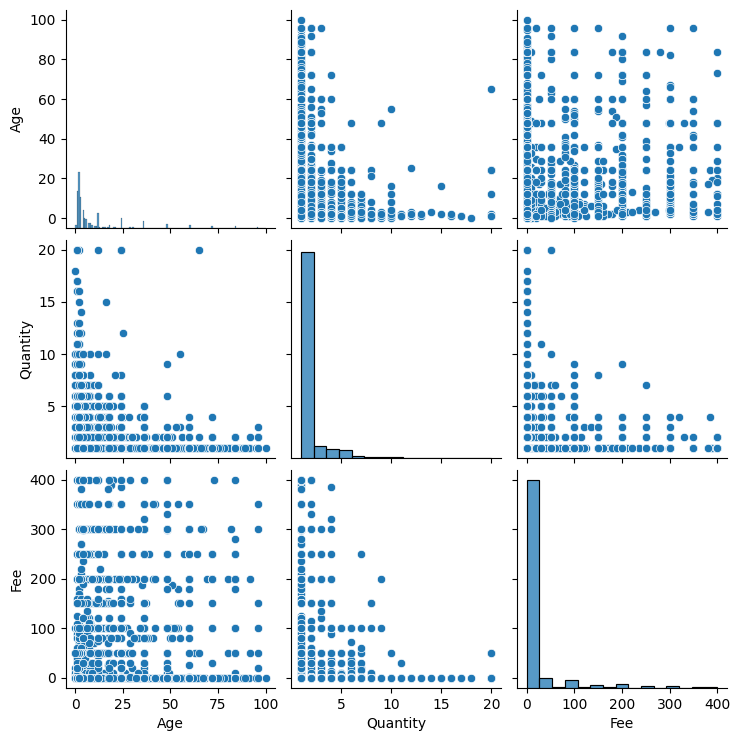

In [126]:
sns.pairplot(df_train_85[['Age', 'Quantity', 'Fee']], diag_kind="hist")

For the decision tree model:
- max_depth: helps to restrict the max depth that the decision tree can be (decrease to help with overfitting)
- min_samples_split: the smallest number that an internal node needs to split into child nodes (increase to help with overfitting)
- min_samples_leaf: the smallest number that an external node needs to split into child nodes (increase to help with overfitting)

# Implementation of Decision Tree from Scikit-learn

In [127]:
# Create a decision tree model (default)
decision_tree_default = DecisionTreeClassifier()
decision_tree_default.fit(df_train_85, adoption_speed_train_85)
adoption_speed_train_prediction_default = decision_tree_default.predict(df_train_85)
adoption_speed_val_prediction_default = decision_tree_default.predict(df_val_5)
adoption_speed_test_prediction_default = decision_tree_default.predict(df_test_10)


# Create a decision tree model (pre-pruning)
decision_tree = DecisionTreeClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=2)
decision_tree.fit(df_train_85, adoption_speed_train_85)
adoption_speed_train_prediction = decision_tree.predict(df_train_85)
adoption_speed_val_prediction = decision_tree.predict(df_val_5)
adoption_speed_test_prediction = decision_tree.predict(df_test_10)

In [128]:
# OFF THE SHELF BASELINE MODEL
print(f"Before Pre-Pruning (default baseline model):")

datasets = [
    (adoption_speed_train_85, adoption_speed_train_prediction_default, 'Training'),
    (adoption_speed_val_5, adoption_speed_val_prediction_default, 'Validation'),
    (adoption_speed_test_10, adoption_speed_test_prediction_default, 'Test')
]

for data, predictions, label in datasets:
  # Calculate and print accuracy, precion, and recall per class (FOR TRAINING)
  accuracy = accuracy_score(data, predictions)
  print(f"\nAccuracy ({label}): {accuracy}")
  # Calculate and print average weighted precision and recall for classes overall
  avg_precision = precision_score(data, predictions, average='weighted', zero_division=0)
  avg_recall = recall_score(data, predictions, average='weighted', zero_division=0)
  print(f'Average weighted precision: {avg_precision}')
  print(f'Average weighted recall: {avg_recall}')
  # Calculate precision and recall for each class separately with zero_division = 0 so that precision or recall as 0.0 for classes with no predicted samples
  precision_per_class = precision_score(data, predictions, average=None, zero_division=0)
  recall_per_class = recall_score(data, predictions, average=None, zero_division=0)
  # Print precision and recall for each class
  for class_label, precision, recall in zip(range(len(precision_per_class)), precision_per_class, recall_per_class):
      print(f'Class {class_label}: Precision = {precision:.2f}, Recall = {recall:.2f}')

Before Pre-Pruning (default baseline model):

Accuracy (Training): 0.9838581424936387
Average weighted precision: 0.9840000811568964
Average weighted recall: 0.9838581424936387
Class 0: Precision = 0.98, Recall = 0.99
Class 1: Precision = 0.97, Recall = 0.99
Class 2: Precision = 0.98, Recall = 0.98
Class 3: Precision = 0.99, Recall = 0.98
Class 4: Precision = 1.00, Recall = 0.98

Accuracy (Validation): 0.33783783783783783
Average weighted precision: 0.33724442034838203
Average weighted recall: 0.33783783783783783
Class 0: Precision = 0.10, Recall = 0.15
Class 1: Precision = 0.31, Recall = 0.29
Class 2: Precision = 0.30, Recall = 0.27
Class 3: Precision = 0.28, Recall = 0.27
Class 4: Precision = 0.47, Recall = 0.50

Accuracy (Test): 0.3290540540540541
Average weighted precision: 0.3368974971699225
Average weighted recall: 0.3290540540540541
Class 0: Precision = 0.04, Recall = 0.07
Class 1: Precision = 0.27, Recall = 0.28
Class 2: Precision = 0.35, Recall = 0.34
Class 3: Precision = 0.29

In [129]:
# USING ADJUSTED MODEL PARAMETERS (Pre-pruning)
print(f"After Pre-Pruning:")
datasets = [
    (adoption_speed_train_85, adoption_speed_train_prediction, 'Training'),
    (adoption_speed_val_5, adoption_speed_val_prediction, 'Validation'),
    (adoption_speed_test_10, adoption_speed_test_prediction, 'Test')
]

predictionAccuracyWithParams_SkLearn = ""
for data, predictions, label in datasets:
  # Calculate and print accuracy, precion, and recall per class (FOR TRAINING)
  accuracy = accuracy_score(data, predictions)
  predictionAccuracyWithParams_SkLearn += f"\nAccuracy ({label}): {accuracy}\n"
  # Calculate and print average weighted precision and recall for classes overall
  avg_precision = precision_score(data, predictions, average='weighted', zero_division=0)
  avg_recall = recall_score(data, predictions, average='weighted', zero_division=0)
  predictionAccuracyWithParams_SkLearn += f"Average weighted precision: {avg_precision}\n"
  predictionAccuracyWithParams_SkLearn += f"Average weighted recall: {avg_recall}\n"
  # Calculate precision and recall for each class separately with zero_division = 0 so that precision or recall as 0.0 for classes with no predicted samples
  precision_per_class = precision_score(data, predictions, average=None, zero_division=0)
  recall_per_class = recall_score(data, predictions, average=None, zero_division=0)
  # Print precision and recall for each class
  for class_label, precision, recall in zip(range(len(precision_per_class)), precision_per_class, recall_per_class):
      predictionAccuracyWithParams_SkLearn += f"Class {class_label}: Precision = {precision:.2f}, Recall = {recall:.2f}\n"

print(predictionAccuracyWithParams_SkLearn)


After Pre-Pruning:

Accuracy (Training): 0.47892811704834604
Average weighted precision: 0.4807700047514783
Average weighted recall: 0.47892811704834604
Class 0: Precision = 0.47, Recall = 0.08
Class 1: Precision = 0.42, Recall = 0.43
Class 2: Precision = 0.42, Recall = 0.50
Class 3: Precision = 0.48, Recall = 0.36
Class 4: Precision = 0.59, Recall = 0.62

Accuracy (Validation): 0.3878378378378378
Average weighted precision: 0.3779235121394643
Average weighted recall: 0.3878378378378378
Class 0: Precision = 0.00, Recall = 0.00
Class 1: Precision = 0.33, Recall = 0.35
Class 2: Precision = 0.34, Recall = 0.40
Class 3: Precision = 0.33, Recall = 0.27
Class 4: Precision = 0.52, Recall = 0.53

Accuracy (Test): 0.35945945945945945
Average weighted precision: 0.3583928556917269
Average weighted recall: 0.35945945945945945
Class 0: Precision = 0.25, Recall = 0.03
Class 1: Precision = 0.31, Recall = 0.33
Class 2: Precision = 0.31, Recall = 0.39
Class 3: Precision = 0.31, Recall = 0.22
Class 4: 

In [130]:
# Perform Cross Valdiation on default and pre-pruned decision trees (Worked with Ben)
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0)
}

scores_default = cross_validate(decision_tree_default, df_train_85, adoption_speed_train_85, cv=10, scoring=scoring_metrics)
print(f'10-fold validation accuracy mean: {scores_default["test_accuracy"].mean()}')
print(f'10-fold validation precision mean: {scores_default["test_precision"].mean()}')
print(f'10-fold validation recall mean: {scores_default["test_recall"].mean()}')

scores_pruned = cross_validate(decision_tree, df_train_85, adoption_speed_train_85, cv=10, scoring=scoring_metrics)
print(f'\n10-fold validation accuracy mean: {scores_pruned["test_accuracy"].mean()}')
print(f'10-fold validation precision mean: {scores_pruned["test_precision"].mean()}')
print(f'10-fold validation recall mean: {scores_pruned["test_recall"].mean()}')

10-fold validation accuracy mean: 0.3222005102111799
10-fold validation precision mean: 0.32381165687188107
10-fold validation recall mean: 0.3222005102111799

10-fold validation accuracy mean: 0.36617194900923666
10-fold validation precision mean: 0.35620848677201206
10-fold validation recall mean: 0.36617194900923666


In [131]:
# Perform T-test for statistical significance
t_stat_accuracy, p_value_accuracy = stats.ttest_rel(scores_default["test_accuracy"], scores_pruned["test_accuracy"])
t_stat_precision, p_value_precision = stats.ttest_rel(scores_default["test_precision"], scores_pruned["test_precision"])
t_stat_recall, p_value_recall = stats.ttest_rel(scores_default["test_recall"], scores_pruned["test_recall"])

print(f'p_value_accuracy = {p_value_accuracy}')
print(f'p_value_precision = {p_value_precision}')
print(f'p_value_recall = {p_value_recall}')


p_value_accuracy = 1.123932391331111e-05
p_value_precision = 0.00011952206730041706
p_value_recall = 1.123932391331111e-05


In [132]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=df_train_85.columns.tolist())
print(r)

|--- Age <= 3.50
|   |--- Sterilized_2 <= 0.50
|   |   |--- State <= 41324.50
|   |   |   |--- Breed1_307 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- Breed1_307 >  0.50
|   |   |   |   |--- Gender_1 <= 0.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- Gender_1 >  0.50
|   |   |   |   |   |--- Vaccinated_1 <= 0.50
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- Vaccinated_1 >  0.50
|   |   |   |   |   |   |--- Age <= 2.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |   |--- Age >  2.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |--- State >  41324.50
|   |   |   |--- Breed1_307 <= 0.50
|   |   |   |   |--- Quantity <= 3.50
|   |   |   |   |   |--- PhotoAmt <= 0.50
|   |   |   |   |   |   |--- Type <= 1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Type >  1.50
|   |   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- PhotoAmt >  0.50
|   |   |   |   |   |   |--- PhotoAmt <= 11.50
|   |   | 

In [133]:
# plot_tree(decision_tree)

# Implementation of Decision Tree from scratch

Citations:
- [SciKitLearn - Libraries for Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [SciKitLearn - Decision Tree Structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)
- [Datacamp -  Decision Tree Classification](https://www.datacamp.com/tutorial/decision-tree-classification-python) (For determining that CART uses the Gini index)
- [GeeksforGeeks - Decision Tree](https://www.geeksforgeeks.org/decision-tree-implementation-python/)
- [GeeksforGeeks - Gini Index](https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/)
- [Youtube video on Decision Tree Classification from scratch](https://www.youtube.com/watch?v=sgQAhG5Q7iY&t=892s)
- [GeeksforGeeks - Binary Tree Data Structure](https://www.geeksforgeeks.org/binary-tree-data-structure/)
- [Auantinsti - How to Calculate Gini Index](https://blog.quantinsti.com/gini-index/)
- [Baeldung - Splitting by Gini Index](https://www.baeldung.com/cs/impurity-entropy-gini-index)
- [ChatGPT - K-Fold Validation Manual Implementation](https://chat.openai.com/share/16a08109-b054-4871-b5f7-177081f75695)
---

In [134]:
# Setup Libraries
import numpy as np

# Implement a Decision Tree from Scratch
  # Hyperparameters to implement: max_depth=10 min_samples_split=2 min_samples_leaf=2
  # Fit using these datasets: df_train_85, adoption_speed_train_85
  # Predict the train, val and test sets (df_train_85, df_val_5, df_test_10)

# Given the features (x) and correspondings class labels (y) (0-4) return the feature with the lowest gini index
def FindMinGiniIndex(x, y):
  # Get the num of columns in x
  numOfColumns = 1
  if x.ndim > 1:
    numOfColumns = x.shape[1]

  # Initialize all gini indexes to 1 which is the worst value
  giniValues = np.ones(numOfColumns)

  for curFeature in range(numOfColumns):
    # Save all of the unique values in the column (look at all rows) and return the counts
    curColumn = x[:]
    if x.ndim > 1:
      curColumn = x[:,curFeature]

    # Remove any "Not a number" values for this column in x and in the result y
    validRows = ~np.isnan(curColumn)
    curColumnFiltered = curColumn[validRows]
    yFiltered = y[validRows]

    uniqueValues, counts = np.unique(curColumnFiltered, return_counts=True)

    if len(uniqueValues) > 0:
      curColGiniValues = np.ones(len(uniqueValues))
      # Find the probability of the uniqueValue also being in a certain class
      for i, uniqueVal in enumerate(uniqueValues):
        # Use a dictionary to count occurences of each class
        classCounts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
        for j, curVal in enumerate(curColumnFiltered):
          if uniqueVal == curVal and y[j] in classCounts:
            classCounts[yFiltered[j]] += 1

        # Calculate the sum of squared probabilies of each class
        probabilitySum = 0.0
        totalCount = counts[i]
        if totalCount > 0:
          for j, curClassCount in classCounts.items():
            probabilitySum += pow((curClassCount / totalCount), 2)
        else:
          probabilitySum = 0.0

        # Calculate the current gini index for this unique value and save it in an array
        # Gini Index = 1 - sum (squared probabilities of each outcome)
        curColGiniValues[i] = 1 - probabilitySum

      # Find the weighted sum of the gini indices for each unique Value
      giniValues[curFeature] = 0
      for i, curGiniVal in enumerate(curColGiniValues):
        probOfCurUniqueValue = counts[i] / len(curColumnFiltered)
        giniValues[curFeature] += (probOfCurUniqueValue) * curGiniVal

  # Find the minimum gini index
  minimumGiniIndex = np.min(giniValues)
  featureToSplit = np.argmin(giniValues)

  return minimumGiniIndex, featureToSplit

def GetBestSplitUsingGiniIndex(x, y, min_samples_leaf):
  # Find the feature to split
  minimumGiniIndex, featureToSplit = FindMinGiniIndex(x, y)
  colToSplit = x[:]
  if x.ndim > 1:
    colToSplit = x[:,featureToSplit]

  # Intialization
  uniqueValues = np.unique(colToSplit)
  uniqueValues = np.sort(uniqueValues)
  xLeftFinal = np.array([])
  yLeftFinal = np.array([])
  xRightFinal = np.array([])
  yRightFinal = np.array([])
  minimumGini = 1
  bestThresh = uniqueValues[0]

  # Find best threshold to split by
  for i in range(1, len(uniqueValues)):
    threshold = (uniqueValues[i - 1] / 2.0) + (uniqueValues[i] / 2.0)

    # Split using the suggested threshold (average between two values in the array)
    xLeft = colToSplit[colToSplit <= threshold]
    yLeft = y[colToSplit <= threshold]
    xRight = colToSplit[colToSplit > threshold]
    yRight = y[colToSplit > threshold]
    currMingini = 1

    if ((len(xLeft) >= min_samples_leaf) and (len(xRight) >= min_samples_leaf)):
      # Adjust the x to have left on the first column and right on the second column with filler None's:
      #  xLeft = [[1]], xRight = [[15],[18]] then
      #  xCombined = [[ 1     None]
      #               [ None  15  ]
      #               [ None  18  ]]
      xLeftFiller = np.empty_like(xRight, dtype=float)
      xLeftFiller.fill(np.nan)
      xRightFiller = np.empty_like(xLeft, dtype=float)
      xRightFiller.fill(np.nan)
      xLeftTemp = np.concatenate((xLeft, xLeftFiller))
      xRightTemp = np.concatenate((xRightFiller, xRight))
      xCombined = np.zeros((len(xRightFiller) + len(xRight), 2))

      xCombined[:, 0] = xLeftTemp
      xCombined[:, 1] = xRightTemp

      # Adjust y to just be on top of the other:
      #  yLeft = [[1],[2]], yRight = [[3]] then
      #  yCombined = [[1]
      #               [2]
      #               [3]]
      yCombined = np.concatenate((yLeft, yRight))

      # Calculate the gini index given first column is xLeft and second column is xRight
      currMingini, column = FindMinGiniIndex(xCombined, yCombined)

    # Keep updating the minimumGini and keep the best splits
    if minimumGini > currMingini:
      minimumGini = currMingini
      bestThresh = threshold

  # Split using the best threshold found
  validLeftRows = x[:] <= bestThresh
  validRightRows = x[:] > bestThresh
  if x.ndim > 1:
    validLeftRows = x[:, featureToSplit] <= bestThresh
    validRightRows = x[:, featureToSplit] > bestThresh

  # Our final output needs to include the entire row with all features not just the feature split on
  xLeftFinal = x[validLeftRows]
  yLeftFinal = y[validLeftRows]
  xRightFinal = x[validRightRows]
  yRightFinal = y[validRightRows]

  return xLeftFinal, yLeftFinal, xRightFinal, yRightFinal, featureToSplit, minimumGini, bestThresh

def printSplit(xL, yL, xR, yR, split, gini, thresh):
  print(f"Split by feature column {split}, with gini index = {gini} and threshold <= {thresh}")

  print("XLeft:")
  print(xL)
  print("YLeft:")
  print(yL)
  print("\nXRight:")
  print(xR)
  print("YRight:")
  print(yR)
  print("\n")

In [135]:
class DecisionTreeNode:
  def __init__(self, num, features, labels, featureToSplit, minimumGini, bestThresh):
    self.x = features
    self.y = labels
    self.childLeft = None
    self.childRight = None
    self.feature = featureToSplit
    self.giniIndex = minimumGini
    self.threshold = bestThresh
    self.majorityClass = self.calculateMajorityClass()

  # Print the node and its children similar to sklearn's exportText function
  def printNode(self, indent=""):
    if not self.isLeaf():
      print(f"{indent}|--- {self.feature} <= {self.threshold}, giniIndex = {self.giniIndex}")
      if self.childLeft is not None and self.childRight is not None:
        if self.childLeft.isLeaf():
          print(f"{indent}|  |--- Class: {self.childLeft.majorityClass}")
        else:
          self.childLeft.printNode(indent + "|  ")
      print(f"{indent}|--- {self.feature} > {self.threshold}, giniIndex = {self.giniIndex}")
      if self.childLeft is not None and self.childRight is not None:
        if self.childRight.isLeaf():
          print(f"{indent}|  |--- Class: {self.childRight.majorityClass}")
        else:
          self.childRight.printNode(indent + "|  ")

  # For predicting, we assign each node with a class based on majority
  def calculateMajorityClass(self):
    return np.argmax(np.bincount(self.y))

  # Boolean check to see if the current leaf is a child
  def isLeaf(self):
    return self.childLeft is None and self.childRight is None or (self.feature is None and self.threshold is None)

# Build the tree given the hyperparameters
class DecisionTree:
  # Initialize the tree with nothing in all parameters
  def __init__(self, root=None, numNodes=0, max_depth=None, min_samples_split=None, min_samples_leaf=None, columnNames=None):
    self.root = root
    self.numNodes = numNodes
    self.columnNames = columnNames
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.min_samples_leaf = min_samples_leaf

  # Define a fit function that builds the tree and uses the recursive call (starts with the root)
  def fit(self, x, y):
    if not isinstance(x, np.ndarray):
      x = x.to_numpy()
    if not isinstance(y, np.ndarray):
      y = y.to_numpy()
    # Call this once and it will create the full tree
    self.root = self.BuildTreeRecursive(x, y, self.max_depth, self.min_samples_split, self.min_samples_leaf, self.columnNames, 0)

  # The recursive function that will stop once we meet the hyperparameter conditions
  def BuildTreeRecursive(self, x, y, max_depth, min_samples_split, min_samples_leaf, columnNames, depth):
    # Stop if we reached max_depth, or not enough samples to split or if everything in y is one class
    if depth == max_depth or len(x) < min_samples_split or len(np.unique(y)) == 1:
      # This is a child node
      return DecisionTreeNode(self.numNodes, x, y, None, None, None)

    else:
      # Define the current node which is the parent
      XLeft, YLeft, XRight, YRight, featureToSplit, minimumGini, bestThresh  = GetBestSplitUsingGiniIndex(x, y, min_samples_leaf)
      parentNode = DecisionTreeNode(self.numNodes, x, y, columnNames[featureToSplit], minimumGini, bestThresh)
      self.numNodes += 1

      # Recursively create the children (left and right)
      parentNode.childLeft = self.BuildTreeRecursive(XLeft, YLeft, max_depth, min_samples_split, min_samples_leaf, columnNames, depth + 1)
      parentNode.childRight = self.BuildTreeRecursive(XRight, YRight, max_depth, min_samples_split, min_samples_leaf, columnNames, depth + 1)

      # After returning from all of the recursive calls, return the root parent node
      return parentNode

  # Return an array of predictions of what class the row should be
  def predict(self, features):
    if not isinstance(features, np.ndarray):
      features = features.to_numpy()
    numRows = features.shape[0]
    prediction = np.zeros((numRows, 1))

    # Save prediction after tracing through the tree
    for row in range(numRows):
      curNode = self.root

      # Check every non-leaf node and keep going through the branches
      while not curNode.isLeaf():
        # Make sure that the features passed in are what the tree was trained on
        try:
          column = self.columnNames.index(curNode.feature)
        except ValueError:
          raise ValueError(f"Feature '{curNode.feature}' not found in trained DecisionTree.")
        if features[row, column] <= curNode.threshold:
          curNode = curNode.childLeft
        else:
          curNode = curNode.childRight

      # This node's prediction is based on its majorityClass
      prediction[row, 0] = curNode.majorityClass

    return prediction

  # Calls print on the root and that node's print function will recursively call the rest of the node's prints
  def PrintTree(self):
    if self.root is not None:
      self.root.printNode()

In [136]:
# Build a tree with parameters (features, labels, max_depth=10, min_samples_split=2, min_samples_leaf=2)
myTree = DecisionTree(max_depth=10, min_samples_split=2, min_samples_leaf=2, columnNames=df_train_85.columns.tolist())
myTree.fit(df_train_85, adoption_speed_train_85)
myTree.PrintTree()

|--- Age <= 84.5, giniIndex = 0.637
|  |--- Age <= 72.5, giniIndex = 0.6533488063660478
|  |  |--- Age <= 60.5, giniIndex = 0.6671368861024033
|  |  |  |--- Age <= 18.5, giniIndex = 0.7077580890001849
|  |  |  |  |--- Age <= 10.5, giniIndex = 0.7082756272786243
|  |  |  |  |  |--- PhotoAmt <= 27.5, giniIndex = 0.4625641025641026
|  |  |  |  |  |  |--- Age <= 7.5, giniIndex = 0.7155053617994964
|  |  |  |  |  |  |  |--- PhotoAmt <= 0.5, giniIndex = 0.5578691184424013
|  |  |  |  |  |  |  |  |--- Quantity <= 5.5, giniIndex = 0.2891156462585034
|  |  |  |  |  |  |  |  |  |--- Age <= 6.5, giniIndex = 0.37037037037037035
|  |  |  |  |  |  |  |  |  |  |--- Class: 4
|  |  |  |  |  |  |  |  |  |--- Age > 6.5, giniIndex = 0.37037037037037035
|  |  |  |  |  |  |  |  |  |  |--- Class: 4
|  |  |  |  |  |  |  |  |--- Quantity > 5.5, giniIndex = 0.2891156462585034
|  |  |  |  |  |  |  |  |  |--- State <= 41328.0, giniIndex = 0.0
|  |  |  |  |  |  |  |  |  |  |--- Class: 4
|  |  |  |  |  |  |  |  |  

In [141]:
# Make predictions using the decision tree built above
adoption_speed_train_prediction = myTree.predict(df_train_85)
adoption_speed_val_prediction = myTree.predict(df_val_5)
adoption_speed_test_prediction = myTree.predict(df_test_10)

# USING ADJUSTED MODEL PARAMETERS (Pre-pruning) with Manual Implementation
print(f"After Pre-Pruning:")
datasets = [
    (adoption_speed_train_85, adoption_speed_train_prediction, 'Training'),
    (adoption_speed_val_5, adoption_speed_val_prediction, 'Validation'),
    (adoption_speed_test_10, adoption_speed_test_prediction, 'Test')
]

predictionAccuracyWithParams_ManualImp = ""
for data, predictions, label in datasets:
  # Calculate and print accuracy, precion, and recall per class
  accuracy = accuracy_score(data, predictions)
  predictionAccuracyWithParams_ManualImp += f"\nAccuracy ({label}): {accuracy}\n"
  # Calculate and print average weighted precision and recall for classes overall
  avg_precision = precision_score(data, predictions, average='weighted', zero_division=0)
  avg_recall = recall_score(data, predictions, average='weighted', zero_division=0)
  predictionAccuracyWithParams_ManualImp += f"Average weighted precision: {avg_precision}\n"
  predictionAccuracyWithParams_ManualImp += f"Average weighted recall: {avg_recall}\n"
  # Calculate precision and recall for each class separately with zero_division = 0 so that precision or recall as 0.0 for classes with no predicted samples
  precision_per_class = precision_score(data, predictions, average=None, zero_division=0)
  recall_per_class = recall_score(data, predictions, average=None, zero_division=0)
  # Print precision and recall for each class
  for class_label, precision, recall in zip(range(len(precision_per_class)), precision_per_class, recall_per_class):
      predictionAccuracyWithParams_ManualImp += f"Class {class_label}: Precision = {precision:.2f}, Recall = {recall:.2f}\n"

print("\n``````````````````````````````````````````````")
print("Using SKLearn Implementation:")
print("-----------------------------", end="")
print(predictionAccuracyWithParams_SkLearn)
print("``````````````````````````````````````````````")
print("Using Manual Implementation:")
print("---------------------------", end="")
print(predictionAccuracyWithParams_ManualImp)


After Pre-Pruning:

``````````````````````````````````````````````
Using SKLearn Implementation:
-----------------------------
Accuracy (Training): 0.47892811704834604
Average weighted precision: 0.4807700047514783
Average weighted recall: 0.47892811704834604
Class 0: Precision = 0.47, Recall = 0.08
Class 1: Precision = 0.42, Recall = 0.43
Class 2: Precision = 0.42, Recall = 0.50
Class 3: Precision = 0.48, Recall = 0.36
Class 4: Precision = 0.59, Recall = 0.62

Accuracy (Validation): 0.3878378378378378
Average weighted precision: 0.3779235121394643
Average weighted recall: 0.3878378378378378
Class 0: Precision = 0.00, Recall = 0.00
Class 1: Precision = 0.33, Recall = 0.35
Class 2: Precision = 0.34, Recall = 0.40
Class 3: Precision = 0.33, Recall = 0.27
Class 4: Precision = 0.52, Recall = 0.53

Accuracy (Test): 0.35945945945945945
Average weighted precision: 0.3583928556917269
Average weighted recall: 0.35945945945945945
Class 0: Precision = 0.25, Recall = 0.03
Class 1: Precision = 0.31

In [138]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


def cross_validate_manual(model, x, y, cv, scoring, random_seed=None):
  # Initialization of the used variables
  accuracy_list = []
  precision_list = []
  recall_list = []
  np.random.seed(random_seed)

  # Per split
  for i in range(cv):
    # set the random seed and then split using it
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=1/cv, random_state=random_seed)
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)

    # Look at each metric that we have passed in and choose a scoring function, only works for the three below
    for metric in scoring:
      if metric == 'accuracy':
        accuracyScore = accuracy_score(y_val, predictions)
        accuracy_list.append(accuracyScore)
      elif metric == 'precision':
        precisionScore = precision_score(y_val, predictions, average='weighted', zero_division=0)
        precision_list.append(precisionScore)
      elif metric == 'recall':
        recallScore = recall_score(y_val, predictions, average='weighted', zero_division=0)
        recall_list.append(recallScore)

  # Populate the result with the three lists kept
  result_dictionary = {
    'test_accuracy': accuracy_list,
    'test_precision': precision_list,
    'test_recall': recall_list
  }

  return result_dictionary


# Perform Cross Valdiation on default and pre-pruned decision trees (Worked with Ben)
# Uses skLearn's model with my cross validation function
scoring_metrics = ['accuracy','precision','recall']
scores_skLearn = cross_validate_manual(decision_tree, df_train_85, adoption_speed_train_85, cv=10, scoring=scoring_metrics)
print
print(f'10-fold validation accuracy mean: {np.mean(scores_skLearn["test_accuracy"])}')
print(f'10-fold validation precision mean: {np.mean(scores_skLearn["test_precision"])}')
print(f'10-fold validation recall mean: {np.mean(scores_skLearn["test_recall"])}')

# Uses a manual implementation of cross validation and model
# Parameters: (model, x, y, cv, scoring)
scoring_metrics = ['accuracy','precision','recall']
scores_manualImp = cross_validate_manual(myTree, df_train_85, adoption_speed_train_85, cv=10, scoring=scoring_metrics)
print(f'\n10-fold validation accuracy mean: {np.mean(scores_manualImp["test_accuracy"])}')
print(f'10-fold validation precision mean: {np.mean(scores_manualImp["test_precision"])}')
print(f'10-fold validation recall mean: {np.mean(scores_manualImp["test_recall"])}')


10-fold validation accuracy mean: 0.3621621621621622
10-fold validation precision mean: 0.355193607437028
10-fold validation recall mean: 0.3621621621621622

10-fold validation accuracy mean: 0.3441971383147854
10-fold validation precision mean: 0.3490032801915513
10-fold validation recall mean: 0.3441971383147854


In [140]:
# Perform T-test for statistical significance between sklearn and manual implementation with hyperparameters
t_stat_accuracy, p_value_accuracy = stats.ttest_rel(scores_skLearn["test_accuracy"], scores_manualImp["test_accuracy"])
t_stat_precision, p_value_precision = stats.ttest_rel(scores_skLearn["test_precision"], scores_manualImp["test_precision"])
t_stat_recall, p_value_recall = stats.ttest_rel(scores_skLearn["test_recall"], scores_manualImp["test_recall"])

print(f'p_value_accuracy = {p_value_accuracy}')
print(f'p_value_precision = {p_value_precision}')
print(f'p_value_recall = {p_value_recall}')

p_value_accuracy = 0.02091565795152443
p_value_precision = 0.6611681344330771
p_value_recall = 0.02091565795152443
